# Maritime Flow Visualization by Country

This notebook analyzes and visualizes maritime freight and passenger flows for a selected country. It integrates port infrastructure data, maritime OD (Origin-Destination) matrices, and country boundaries to provide insights into inbound and outbound flows at each port. The workflow includes data loading, filtering, aggregation, visualization, and summary statistics, supporting both freight and passenger maritime flows. The output includes maps and tables summarizing flows for each port, with a focus on the selected country.


## 1. Import Required Libraries and Country Boundaries

This section imports all necessary Python libraries and loads the country boundaries dataset. It ensures the spatial data is in the correct coordinate reference system and filters the boundaries to the European region, preparing the context for subsequent maritime flow analysis.


In [1]:
# HIDE CODE
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from pathlib import Path
import sys
from miraca_book.download import download

sys.path.append(str(Path().resolve().parent))

from utils.miraca_flow_utils import (
    plot_bubble_map, get_country_geometry, get_id_column, 
    aggregate_od_flows, merge_flows_with_nodes, print_transport_summary,
    load_europe_countries
)

warnings.filterwarnings('ignore')

outpath = Path('~/.miraca').expanduser() / "output"
outpath.mkdir(exist_ok=True, parents=True)
base_path = download('https://zenodo.org/records/18428552/files/MIRACA_Transport_Flow_Model.zip?download=1') / 'data'

In [2]:
# Load European countries using shared function
europe_countries = load_europe_countries(base_path)

Loaded 54 countries in Europe region


## 2. Load Maritime Network and OD Data

This section loads the maritime network data, including port locations and maritime OD (Origin-Destination) matrices for freight and passengers. It identifies the selected country, extracts its geometry, and filters the port dataset to include only ports within the country's boundaries. This prepares the data for flow aggregation and analysis.


In [3]:
# Load maritime data
print("Loading maritime network data...")

maritime_freight_od = pd.read_parquet(base_path / 'ODs_BE/belgium_maritime_freight_OD.parquet')
maritime_passenger_od = pd.read_parquet(base_path / 'ODs_BE/belgium_maritime_passenger_OD.parquet')
ports_gdf = gpd.read_parquet(base_path / "Infra_BE/belgium_ports.parquet").to_crs("EPSG:4326")

# Set the selected country
SELECTED_COUNTRY = "Belgium"

# Extract country geometry using helper function
country_row, country_geom = get_country_geometry(europe_countries, SELECTED_COUNTRY)

# Filter ports by spatial relation
country_ports = ports_gdf[ports_gdf.within(country_geom)].copy()

# Determine ID column for ports using helper function
port_id_candidates = ['port_code', 'id', 'node_id', 'code', 'UNLOCODE', 'unlocode']
port_id_col = get_id_column(country_ports, port_id_candidates)

# Build code lists used for OD filtering
port_codes = country_ports[port_id_col].astype(str).tolist()

print("... network loaded")

Loading maritime network data...
... network loaded


## 3. Calculate Maritime Flows (Inbound and Outbound)

This section filters and aggregates the maritime OD data to calculate inbound and outbound freight and passenger flows for each port in the selected country. It merges these flows with port data, combines terminals belonging to the same port, and prepares summary tables for both freight and passenger movements.


In [4]:
# --- Process Maritime Freight Flows ---
maritime_freight_inbound, maritime_freight_outbound, freight_inbound_agg, freight_outbound_agg = \
    aggregate_od_flows(maritime_freight_od, port_codes)

print(f"Maritime freight flows:")
print(f"  Inbound: {len(maritime_freight_inbound)} connections")
print(f"  Outbound: {len(maritime_freight_outbound)} connections")
print(f"  Total inbound flow: {maritime_freight_inbound['value'].sum():,.0f} ths tons/year")
print(f"  Total outbound flow: {maritime_freight_outbound['value'].sum():,.0f} ths tons/year")

country_ports_flow = merge_flows_with_nodes(
    country_ports, port_id_col, freight_inbound_agg, freight_outbound_agg,
    name_col='port_name', corridor_col='CORRIDORS'
)
print(f"\n✓ Aggregated flows for {len(country_ports_flow)} ports (terminals combined)")

# --- Process Maritime Passenger Flows ---
maritime_passenger_inbound, maritime_passenger_outbound, pass_inbound_agg, pass_outbound_agg = \
    aggregate_od_flows(maritime_passenger_od, port_codes)

# Rename columns for passengers
pass_inbound_agg.columns = ['port_id', 'inbound_passengers']
pass_outbound_agg.columns = ['port_id', 'outbound_passengers']

print(f"\nMaritime passenger flows:")
print(f"  Inbound: {len(maritime_passenger_inbound)} connections")
print(f"  Outbound: {len(maritime_passenger_outbound)} connections")
print(f"  Total inbound flow: {maritime_passenger_inbound['value'].sum():,.0f} passengers/year")
print(f"  Total outbound flow: {maritime_passenger_outbound['value'].sum():,.0f} passengers/year")

country_ports_passengers = merge_flows_with_nodes(
    country_ports, port_id_col, pass_inbound_agg, pass_outbound_agg,
    inbound_col='inbound_passengers', outbound_col='outbound_passengers',
    name_col='port_name', corridor_col='CORRIDORS'
)
print(f"✓ Aggregated passenger flows for {len(country_ports_passengers)} ports (terminals combined)")

Maritime freight flows:
  Inbound: 627 connections
  Outbound: 604 connections
  Total inbound flow: 104,278 ths tons/year
  Total outbound flow: 33,071 ths tons/year

✓ Aggregated flows for 5 ports (terminals combined)

Maritime passenger flows:
  Inbound: 32799 connections
  Outbound: 32915 connections
  Total inbound flow: 5,291 passengers/year
  Total outbound flow: 428 passengers/year
✓ Aggregated passenger flows for 5 ports (terminals combined)


## 4. Visualize Maritime Flows

This section generates visualizations of maritime flows using bubble maps. It displays inbound and outbound freight and passenger flows for each port, highlighting the spatial distribution and magnitude of flows across the selected country's ports.


Generating bubble map subplots...


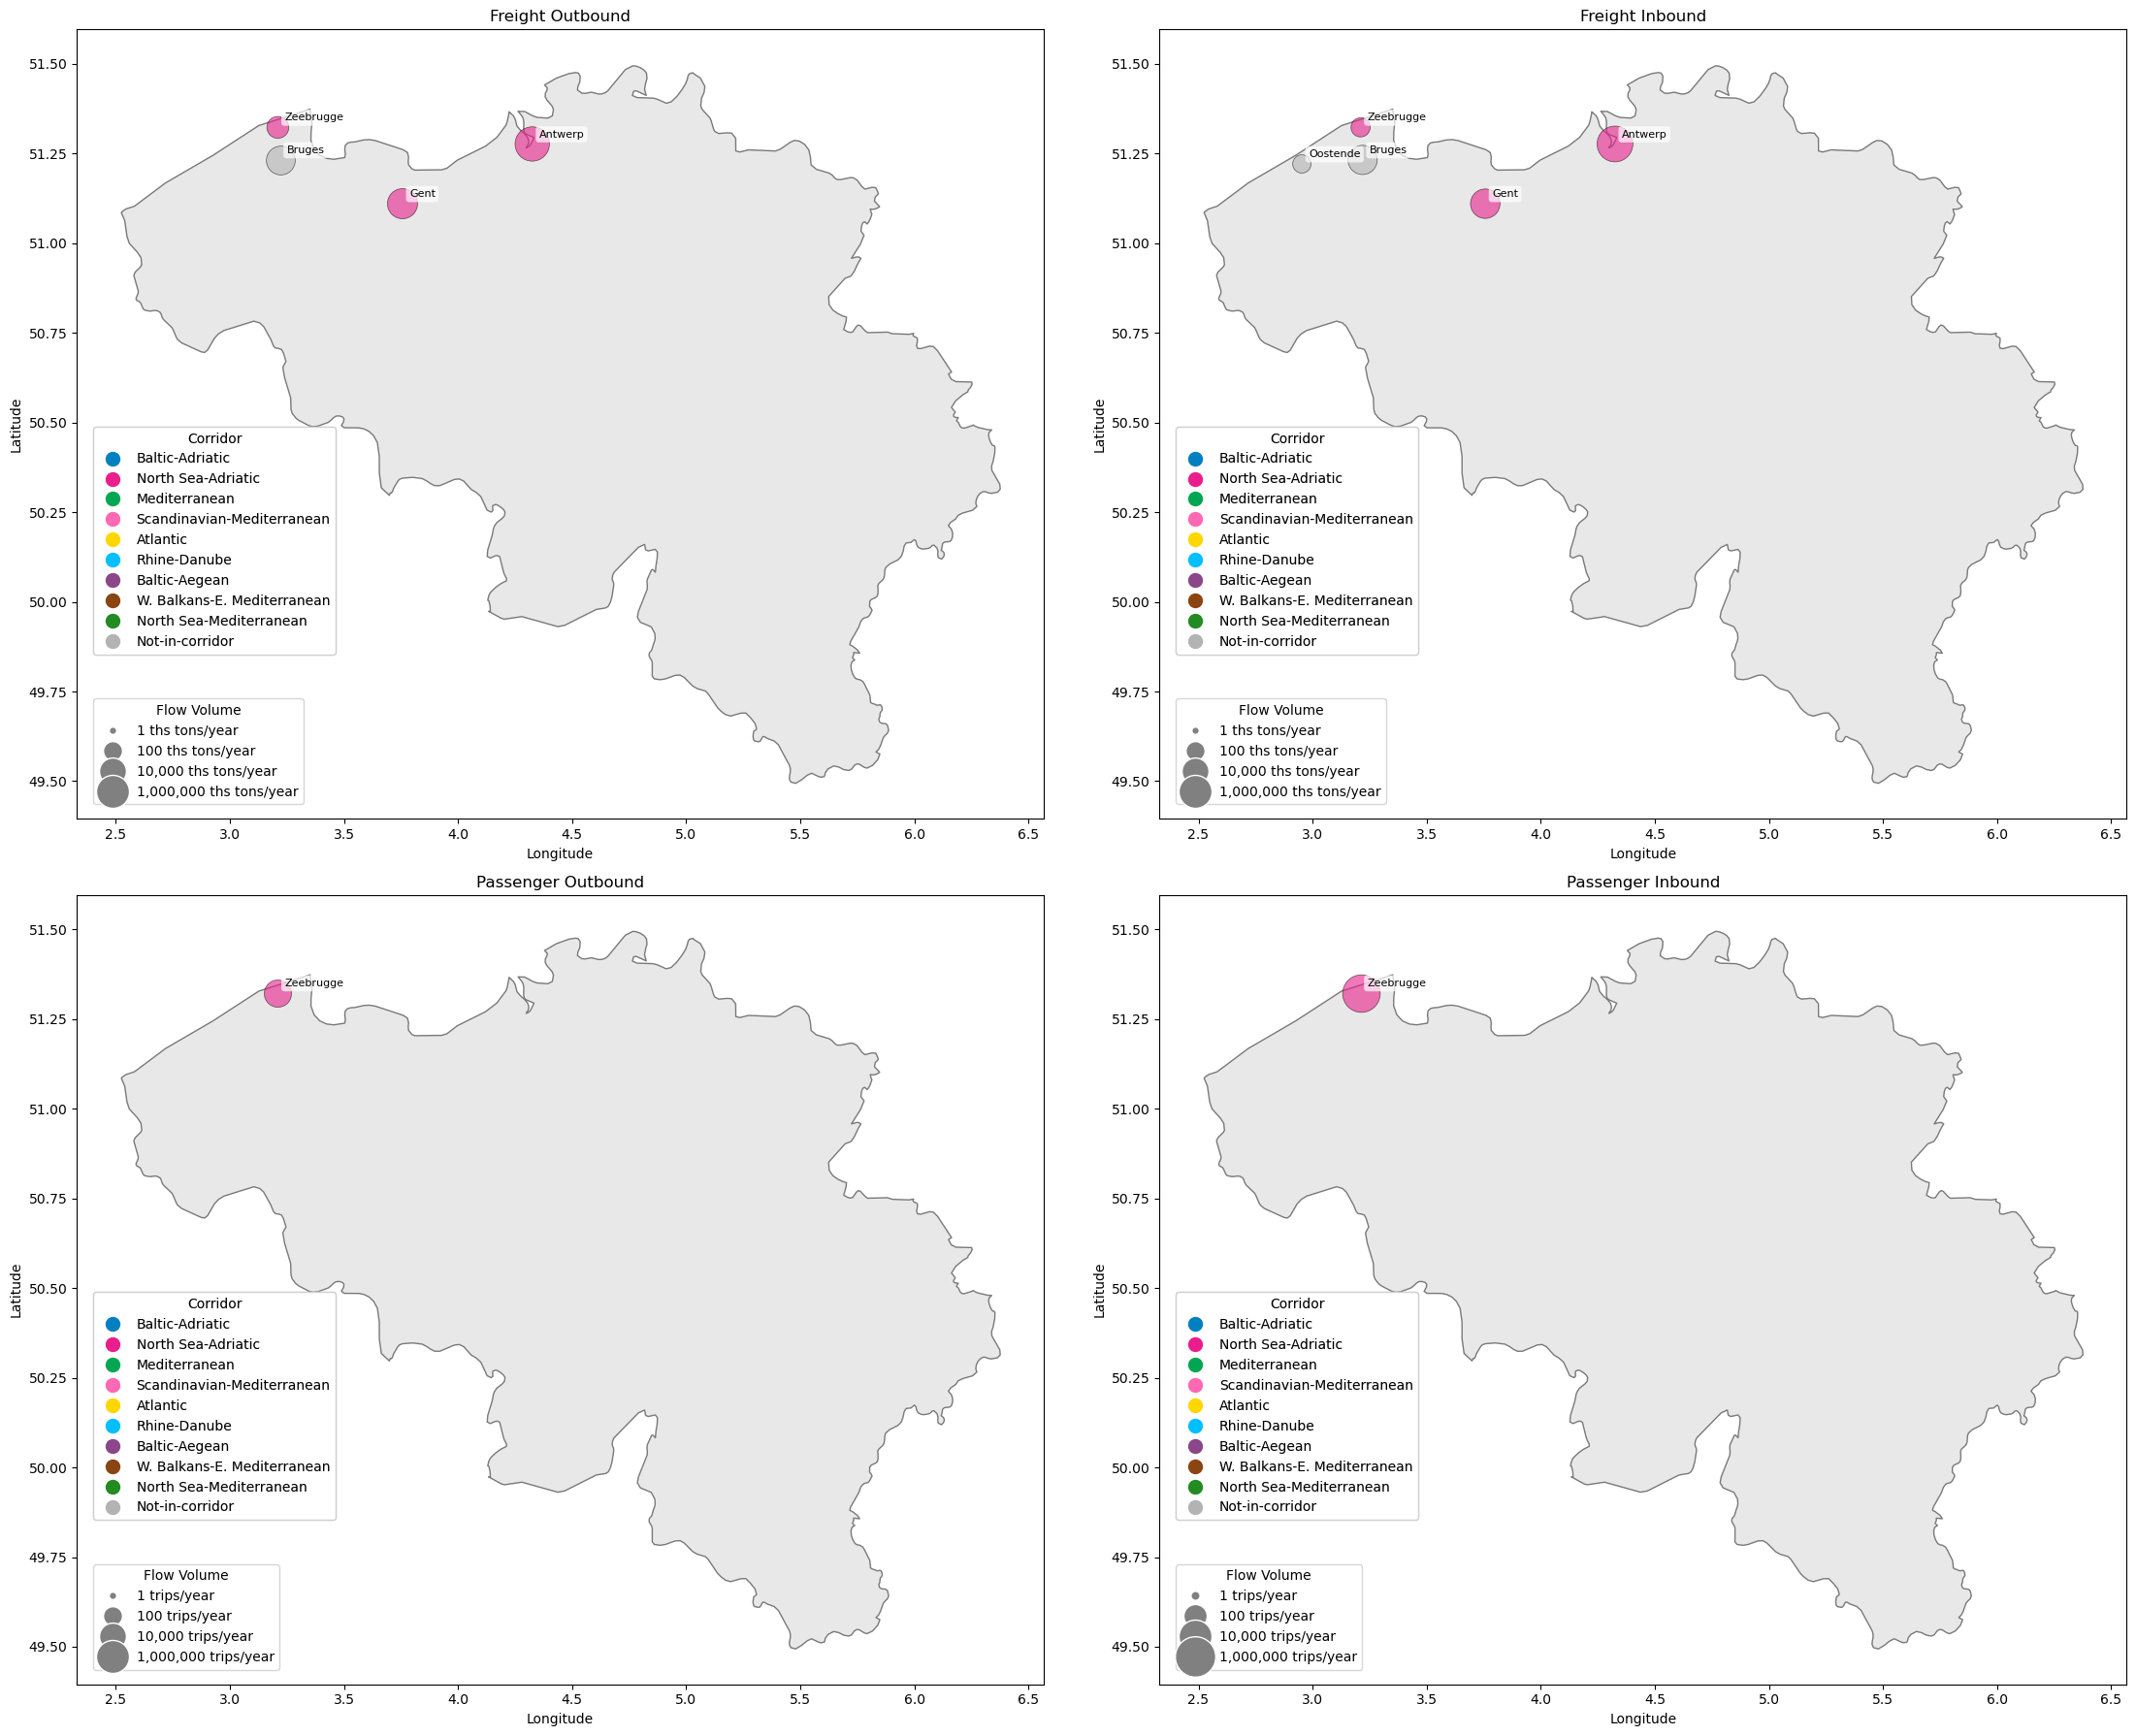

In [5]:
print("Generating bubble map subplots...")
country_name='BELGIUM'
fig, axes = plt.subplots(2, 2, figsize=(24, 18))
axes = axes.flatten()

# 1. Freight Outbound
plot_bubble_map(
    axes[0], country_ports_flow, 'outbound_flow', 'CORRIDORS', country_row, SELECTED_COUNTRY,
    'Outbound', 'Freight', outpath, scale_factor=100, flow_values=[1, 100, 10000, 1000000]
)
axes[0].set_title('Freight Outbound')

# 2. Freight Inbound
plot_bubble_map(
    axes[1], country_ports_flow, 'inbound_flow', 'CORRIDORS', country_row, SELECTED_COUNTRY,
    'Inbound', 'Freight', outpath, scale_factor=100, flow_values=[1, 100, 10000, 1000000]
)
axes[1].set_title('Freight Inbound')

# 3. Passenger Outbound
plot_bubble_map(
    axes[2], country_ports_passengers, 'outbound_passengers', 'CORRIDORS', country_row, SELECTED_COUNTRY,
    'Outbound', 'Passenger', outpath, scale_factor=100, flow_values=[1, 100, 10000, 1000000]
)
axes[2].set_title('Passenger Outbound')

# 4. Passenger Inbound
plot_bubble_map(
    axes[3], country_ports_passengers, 'inbound_passengers', 'CORRIDORS', country_row, SELECTED_COUNTRY,
    'Inbound', 'Passenger', outpath, scale_factor=150, flow_values=[1, 100, 10000, 1000000]
)
axes[3].set_title('Passenger Inbound')

filename = f'Maritime_bubbles_{country_name.replace(" ", "_")}.png'
plt.savefig(outpath / filename, dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## 5. Summary Statistics

This section provides summary statistics for the selected country's maritime infrastructure and flows. It reports the number of ports, total inbound and outbound freight and passenger flows, and net flows, offering a concise overview of the country's maritime activity.


In [6]:
print_transport_summary(
    SELECTED_COUNTRY, len(country_ports),
    country_ports_flow, country_ports_passengers,
    'inbound_flow', 'outbound_flow',
    'inbound_passengers', 'outbound_passengers',
    freight_unit='tons/day', passenger_unit='passengers/day',
    node_type='Ports'
)

SUMMARY FOR Belgium

Infrastructure:
  Ports: 238

Freight Flows:
  Ports with inbound flow: 5
  Ports with outbound flow: 4
  Total inbound: 11,635,683 tons/day
  Total outbound: 3,364,819 tons/day
  Net flow: -8,270,863 tons/day

Passenger Flows:
  Ports with inbound flow: 1
  Ports with outbound flow: 1
  Total inbound: 153,431 passengers/day
  Total outbound: 12,424 passengers/day
  Net flow: -141,007 passengers/day
